Initial Omega_rc: [[0 9]
 [9 0]
 [5 5]]
Reconstruction error: 0.8610179311987516
rank(O_T): 24


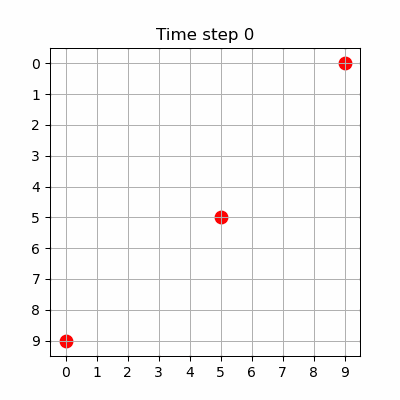

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# -----------------------
# Parameters
# -----------------------
H, W = 10, 10
n = H * W
T = 200
noise_level = 0

rng = np.random.default_rng(0)


Omega_rc = np.array([
    [0, W - 1],
    [H - 1, 0],
    [H//2, W//2]
])

m = Omega_rc.shape[0]

print("Initial Omega_rc:", Omega_rc)

# -----------------------
# Helper functions
# -----------------------
def rc_to_idx(r, c):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        idx = rc_to_idx(r, c)
        P[row, idx] = 1.0
    return P

def move_policy(Omega_rc, t, H, W):
    """
    Two robots:
    - Robot 0: original zig-zag
    - Robot 1: reversed zig-zag
    """
    Omega_next = Omega_rc.copy()

    for i, (r, c) in enumerate(Omega_rc):

        # ---------- Robot 0: ORIGINAL zig-zag ----------
        if i == 0:
            if r % 2 == 0:  # even rows → move left
                c_new = c - 1
                if c_new < 0:
                    r = min(r + 1, H - 1)
                    c_new = 0
            else:           # odd rows → move right
                c_new = c + 1
                if c_new >= W:
                    r = min(r + 1, H - 1)
                    c_new = W - 1

        # ---------- Robot 1: REVERSED zig-zag ----------
        else:
            if r % 2 == 0:  # even rows → move right
                c_new = c + 1
                if c_new >= W:
                    r = max(r - 1, 0)
                    c_new = W - 1
            else:           # odd rows → move left
                c_new = c - 1
                if c_new < 0:
                    r = max(r - 1, 0)
                    c_new = 0

        Omega_next[i] = [r, c_new]

    return Omega_next



# -----------------------
# System definition
# -----------------------
G = rng.normal(scale=0.15, size=(n, n))
G = G / np.linalg.norm(G)
G = G @ G.T

v0_true = rng.normal(size=n)
v0_true /= np.linalg.norm(v0_true)

# -----------------------
# Storage
# -----------------------
O_blocks = []
ys = []
positions = []

v_t = v0_true.copy()
G_power = np.eye(n)

# -----------------------
# Simulation loop
# -----------------------
for t in range(T + 1):

    # store robot positions (for visualization)
    positions.append(Omega_rc.copy())

    # selector matrix
    P_t = selector_from_rc(Omega_rc, H, W)

    # measurement
    y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
    ys.append(y_t)

    # observability block
    if t == 0:
        O_blocks.append(P_t @ G_power)
    else:
        G_power = G_power @ G
        O_blocks.append(P_t @ G_power)

    # system evolution
    v_t = G @ v_t

    # robot motion (static)
    Omega_rc = move_policy(Omega_rc, t, H, W)

# -----------------------
# Stack & reconstruct
# -----------------------
y_stacked = np.concatenate(ys, axis=0)
O_T = np.vstack(O_blocks)

v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
err = np.linalg.norm(v0_hat - v0_true)

print("Reconstruction error:", err)
print("rank(O_T):", np.linalg.matrix_rank(O_T))

# -----------------------
# Visualization (GIF)
# -----------------------
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-0.5, W - 0.5)
ax.set_ylim(H - 0.5, -0.5)
ax.set_xticks(range(W))
ax.set_yticks(range(H))
ax.grid(True)

scat = ax.scatter([], [], s=80, c="red")

def init():
    scat.set_offsets(np.empty((0, 2)))
    return (scat,)

def update(frame):
    Omega = positions[frame]
    xy = np.column_stack([Omega[:, 1], Omega[:, 0]])  # (x=col, y=row)
    scat.set_offsets(xy)
    ax.set_title(f"Time step {frame}")
    return (scat,)

ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(positions),
    init_func=init,
    interval=500,
    blit=True
)

gif_path = "robot_static.gif"
ani.save(gif_path, writer=animation.PillowWriter(fps=2))
plt.close(fig)

display(Image(filename=gif_path))

